In [1]:
import torch
import torch.nn as nn
import torchvision.models as models
from torchvision.transforms import transforms
from torchvision.datasets import ImageFolder
import cv2
import numpy as np
from tqdm import tqdm
import matplotlib.pyplot as plt
import torchvision

In [2]:
model = models.vgg16(pretrained=True).eval()
with open("./data/imagenet_labels.txt") as f:
    classes = eval(f.read())

In [3]:
def readAndPreprocess(img_path):
    # Read and convert from BGR to RGB
    img = cv2.imread(img_path)[..., ::-1]
    # Resize
    img = cv2.resize(img, (224, 224))
    # Convert to tensor, normalize and flatten 
    transform = transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]) # From ImageNet 
    ])
    img = transform(img).unsqueeze_(0)
    return img

In [4]:
def torchIMG(img):
  transform = transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]) # From ImageNet 
    ])
  ret = transform(img).unsqueeze_(0)
  return ret

def npIMG(img):
  std_correction = np.asarray([0.229, 0.224, 0.225]).reshape(3, 1, 1)
  
  #define mean correction to be made
  mean_correction = np.asarray([0.485, 0.456, 0.406]).reshape(3, 1, 1)
  
  #convert the tensor img to numpy img and de normalize 
  npimg = np.multiply(img.numpy(), std_correction) + mean_correction
  npimg = npimg[0]
  
  #plot the numpy image
  print(npimg.shape)
  npimg = np.transpose(npimg, (1, 2, 0))

  return npimg


def imshow(img, title='', batch_size=1):
  
  """Custom function to display the image using matplotlib"""
  
  
  npimg = npIMG(img)
  
  #plot the numpy image
  plt.figure(figsize = (batch_size * 4, 4))
  plt.axis("off")
  plt.imshow(npimg)
  plt.title(title)
  plt.show()


(3, 224, 224)


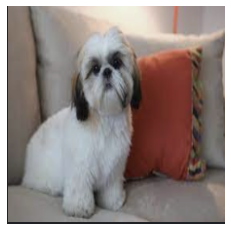

In [5]:
shihTzu = readAndPreprocess('./data/imgs/shih.png')
imshow(shihTzu)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


(3, 224, 224)


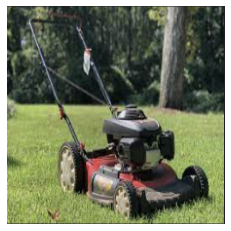

In [6]:
lawnMower = readAndPreprocess('./data/imgs/lawnMower.png')
imshow(lawnMower)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


(3, 224, 224)


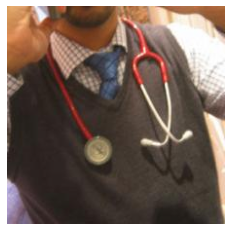

In [60]:
steth = readAndPreprocess('./data/imgs/steth.JPEG')
imshow(steth)

In [7]:
def getRotationInvariance(img, theta, model):
    rots = getArrayOfRots(img, theta)
    _, class_= torch.max(model(img.float()).data, 1)
    graphRots(rots, theta, model, class_)

def getArrayOfRots(img, theta=60):
    imgNp = npIMG(img)
    arr = []
    for thet in range(0,361,theta):
        height, width = imgNp.shape[:2]
        center = (width/2, height/2)
        
        rotate_matrix = cv2.getRotationMatrix2D(center=center, angle=thet, scale=1)
        
        rotated_image = cv2.warpAffine(src=imgNp, M=rotate_matrix, dsize=(width, height))
        arr.append(torchIMG(rotated_image))
    return arr

def graphRots(rots, theta, model, label):
    rotConfArr = []
    
    for ind, angle in enumerate(range(0, 361, theta)):
        output = nn.functional.softmax(model(rots[ind].float()), dim=1)
        prob = output.tolist()[0][label]
        rotConfArr.append(prob)
    print(label)
    plt.plot(range(0, 361, theta), rotConfArr, label=classes[label.item()])
    plt.legend()
    

(3, 224, 224)
tensor([155])
(3, 224, 224)
tensor([621])
(3, 224, 224)
tensor([823])


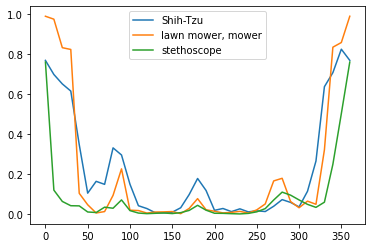

In [61]:
getRotationInvariance(shihTzu, 10, model)
getRotationInvariance(lawnMower, 10, model)
getRotationInvariance(steth, 10, model)
plt.show()

In [57]:
def getTranslationInvariance(img,model, d=20, b=100):
    rots = getArrayOfTrans(img, d, b)
    _, class_= torch.max(model(img.float()).data, 1)
    graphTrans(rots, b, d, model, class_)

def getArrayOfTrans(img, d =20, b=100):
    imgNp = npIMG(img)
    arr = []
    for thet in range(1,b+1, d):
        im2 = np.zeros_like(imgNp)
        im2[:-thet, :, :] = imgNp[thet:, :, :] 
        arr.append(torchIMG(im2))
    return arr

def graphTrans(rots, b, d, model, label):
    rotConfArr = []
    
    for ind, angle in enumerate(range(0, b, d)):
        output = nn.functional.softmax(model(rots[ind].float()), dim=1)
        prob = output.tolist()[0][label]
        rotConfArr.append(prob)
    plt.plot(range(0, b, d), rotConfArr, label=classes[label.item()])
    plt.legend()
    

(3, 224, 224)
(3, 224, 224)
(3, 224, 224)


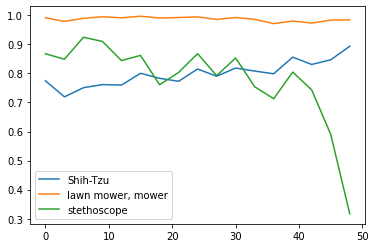

In [64]:
getTranslationInvariance(shihTzu, model, b=50, d=3)
getTranslationInvariance(lawnMower, model, b=50, d=3)
getTranslationInvariance(steth, model, b=50, d=3)

In [ ]:
def getZoomInvariance(img,model, d=20, b=100):
    rots = getArrayOfZoom(img, d, b)
    _, class_= torch.max(model(img.float()).data, 1)
    graphZoom(rots, b, d, model, class_)

def getArrayOfZoom(img, d =20, b=100):
    imgNp = npIMG(img)
    arr = []
    for thet in range(1,b+1, d):
        im2 = np.zeros_like(imgNp)
        im2[:-thet, :, :] = imgNp[thet:, :, :] 
        arr.append(torchIMG(im2))
    return arr

def graphZoom(rots, b, d, model, label):
    rotConfArr = []
    
    for ind, angle in enumerate(range(0, b, d)):
        output = nn.functional.softmax(model(rots[ind].float()), dim=1)
        prob = output.tolist()[0][label]
        rotConfArr.append(prob)
    plt.plot(range(0, b, d), rotConfArr, label=classes[label.item()])
    plt.legend()
    